## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

In [76]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [77]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

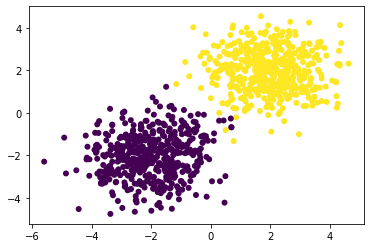

In [78]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [79]:
net = Sequential()
net.add(Linear(2, 2))
net.add(ReLU())
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
ReLU
Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [80]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [81]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

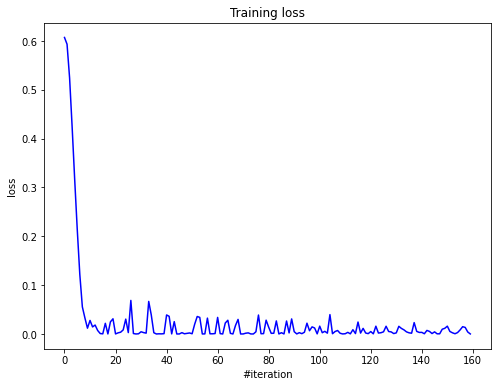

Current loss: 0.000058


In [82]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [83]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [84]:
# Your code goes here. ################################################

def one_hot_encode(y):
    y_encoded = []
    for i in y:
        i_encode = [0] * 10
        i_encode[i] = 1
        y_encoded.append(i_encode)
    return y_encoded

y_train_encoded = np.array(one_hot_encode(y_train))
y_test_encoded = np.array(one_hot_encode(y_test))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [85]:
# Your code goes here. ################################################

def plot_history(lh, lh_BN = None):
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.title("Training loss")
    plt.xlabel("iteration num")
    plt.ylabel("loss")
    if lh_BN is not None:
        plt.plot(lh, 'b', color='blue', label='without BatchNorm')
        plt.plot(lh_BN, 'b', color='red', label='with BatchNorm')
        plt.legend()
    else:
        plt.plot(lh, 'b')
    plt.ylim(0, 1)
    plt.show()

import time

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

def evaluate_net(net, n_epoch, batch_size, criterion):
    loss_history = []
    start = time.time()

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train_encoded), batch_size):
            net.zeroGradParameters()
            # forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            # backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            # update weights
            sgd_momentum(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)
            loss_history.append(loss)

        # plot_history(loss_history)
        # print('Current loss: ' + str(loss))

    end = time.time()
    ttime = end - start
    print('Time: {:.2f}'.format(ttime))
    print('last loss: ' + str(loss_history[-1]))

    return loss_history

# for fast building of nets:
def build_net(activation_layer, with_batchnorm=False):
    net = Sequential()
    net.add(Flatten())
    net.add(Linear(784, 49))  # 28^2 = 784
    if with_batchnorm:
        net.add(BatchNormalization(0.))
        net.add(ChannelwiseScaling(49))
    net.add(activation_layer)
    net.add(Linear(49,10))
    if with_batchnorm:
        net.add(BatchNormalization(0.))
        net.add(ChannelwiseScaling(10))

    net.add(LogSoftMax())

    return net

### ReLU:

In [86]:
criterion = ClassNLLCriterion()
n_epoch = 8
batch_size = 1000

# without batchNorm
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
net = build_net(ReLU())
print(net)
loss_hist = evaluate_net(net, n_epoch, batch_size, criterion)
print()

Flatten
Linear 784 -> 49
ReLU
Linear 49 -> 10
LogSoftMax

Time: 103.48
last loss: 0.1564302399082977



In [87]:
# with batchNorm

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
net = build_net(ReLU(), with_batchnorm=True)
print(net)
loss_hist_BN = evaluate_net(net, n_epoch, batch_size, criterion)
print()

Flatten
Linear 784 -> 49
BatchNormalization
ChannelwiseScaling
ReLU
Linear 49 -> 10
BatchNormalization
ChannelwiseScaling
LogSoftMax

Time: 104.45
last loss: 0.05630261568958175



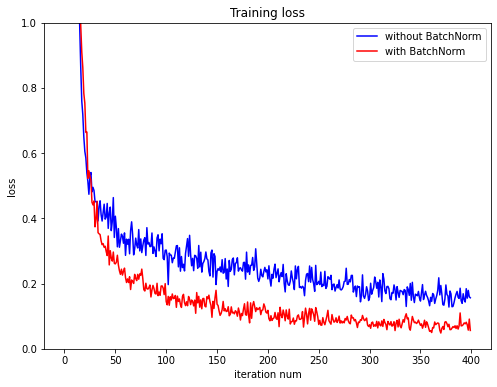

In [88]:
plot_history(loss_hist, loss_hist_BN)

### Leaky ReLU:

In [89]:
# without batchNorm
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
net = build_net(LeakyReLU())
print(net)
loss_hist = evaluate_net(net, n_epoch, batch_size, criterion)
print()

# with batchNorm
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
net = build_net(LeakyReLU(), with_batchnorm=True)
print(net)
loss_hist_BN = evaluate_net(net, n_epoch, batch_size, criterion)
print()

Flatten
Linear 784 -> 49
LeakyReLU
Linear 49 -> 10
LogSoftMax

Time: 101.57
last loss: 0.13369865714220547

Flatten
Linear 784 -> 49
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 49 -> 10
BatchNormalization
ChannelwiseScaling
LogSoftMax

Time: 102.86
last loss: 0.06238101495702303



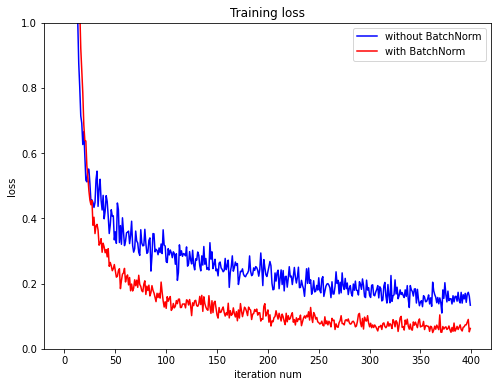

In [90]:
plot_history(loss_hist, loss_hist_BN)


### ELU:

In [91]:
# without batchNorm
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
net = build_net(ELU())
print(net)
loss_hist = evaluate_net(net, n_epoch, batch_size, criterion)
print()

# with batchNorm
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
net = build_net(ELU(), with_batchnorm=True)
print(net)
loss_hist_BN = evaluate_net(net, n_epoch, batch_size, criterion)
print()

Flatten
Linear 784 -> 49
ELU
Linear 49 -> 10
LogSoftMax

Time: 105.98
last loss: 0.15667905859103906

Flatten
Linear 784 -> 49
BatchNormalization
ChannelwiseScaling
ELU
Linear 49 -> 10
BatchNormalization
ChannelwiseScaling
LogSoftMax

Time: 102.62
last loss: 0.11552651768069437



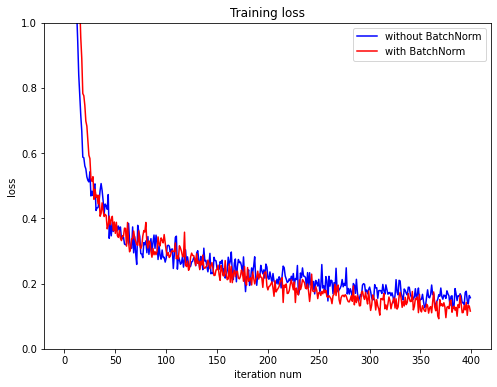

In [92]:
plot_history(loss_hist, loss_hist_BN)

### SoftPlus:

In [93]:
# without batchNorm
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
net = build_net(SoftPlus())
print(net)
loss_hist = evaluate_net(net, n_epoch, batch_size, criterion)
print()

# with batchNorm
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
net = build_net(SoftPlus(), with_batchnorm=True)
print(net)
loss_hist_BN = evaluate_net(net, n_epoch, batch_size, criterion)
print()

Flatten
Linear 784 -> 49
SoftPlus
Linear 49 -> 10
LogSoftMax

Time: 100.60
last loss: 0.18407745389326852

Flatten
Linear 784 -> 49
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 49 -> 10
BatchNormalization
ChannelwiseScaling
LogSoftMax

Time: 102.69
last loss: 0.1300304324678288



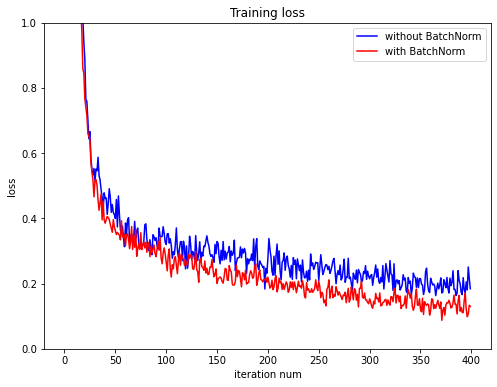

In [94]:
plot_history(loss_hist, loss_hist_BN)

### Adam optimizer:

In [95]:
# some new misc for adam optimizer:
optimizer_config = {'learning_rate': 0.1, 'beta1': 0.9, 'beta2': 0.95, 'epsilon': 1e-6}
optimizer_state = {}

def evaluate_adam_net(net, n_epoch, batch_size, criterion):
    loss_history = []
    start = time.time()

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train_encoded), batch_size):
            net.zeroGradParameters()
            # forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            # backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            # update weights
            adam_optimizer(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)
            loss_history.append(loss)

        # plot_history(loss_history)
        # print('Current loss: ' + str(loss))

    end = time.time()
    ttime = end - start
    print('Time: {:.2f}'.format(ttime))
    print('last loss: ' + str(loss_history[-1]))

    return loss_history

In [96]:
# testing of net with adam
# I took LeakyReLU because it showed pretty good results
# and because it pretty easy to compute
# (although there is no particular gain in execution time)

# without batchNorm
optimizer_config = {'learning_rate': 0.1, 'beta1': 0.9, 'beta2': 0.95, 'epsilon': 1e-6}
optimizer_state = {}
net = build_net(LeakyReLU())
print(net)
loss_hist = evaluate_adam_net(net, n_epoch, batch_size, criterion)
print()

# with batchNorm
optimizer_config = {'learning_rate': 0.1, 'beta1': 0.9, 'beta2': 0.95, 'epsilon': 1e-6}
optimizer_state = {}
net = build_net(LeakyReLU(), with_batchnorm=True)
print(net)
loss_hist_BN = evaluate_adam_net(net, n_epoch, batch_size, criterion)
print()

Flatten
Linear 784 -> 49
LeakyReLU
Linear 49 -> 10
LogSoftMax

Time: 104.74
last loss: 0.17078903275842144

Flatten
Linear 784 -> 49
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 49 -> 10
BatchNormalization
ChannelwiseScaling
LogSoftMax

Time: 101.96
last loss: 0.07799465688210808



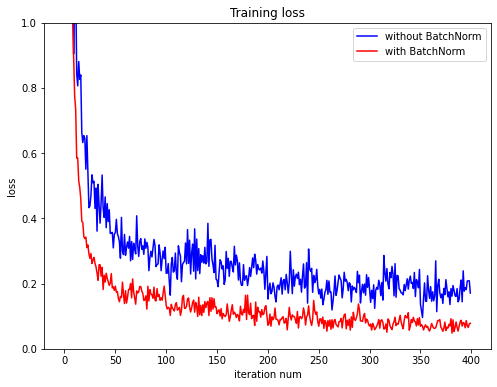

In [97]:
plot_history(loss_hist, loss_hist_BN)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [98]:
# Your answer goes here. ################################################

### Мой answer
Сначала я попробовал сеть с одним линейным слоем и каких-то заметных улучшений от
BatchNormalization не наблюдалось (что и логично).

Тут же, с двумя линейными слоями, можно заметить положительное влияние
BatchNormalization на loss. Можно отметить, что влияние BatchNormalization
наиболее заметно на ломаных функциях активации.
Также можно заметить, что в данных условиях функция активации заметного влияния
 на время исполнения не оказывает. Хотя ReLU и LeakyReLU должны быть
 быстрее (вероятно, на более серьёзных задачах это будет заметно).

Сравнивая же результаты для (LeakyReLU, sgd_momentum) и (LeakyReLU, Adam)
можно сказать, что результаты первой связки мне понравились больше. Во втором
случае наблюдалось более быстрое схождение, но при этом и шумов было больше.
Положительное влияние BatchNormalization на схождение loss-функции
достаточно хорошо заметно в обоих случаях.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [99]:
# Your code goes here. ################################################

def get_accuracy(prediction, y_true):
    return np.mean(np.argmax(prediction, axis=1) == np.argmax(y_true, axis=1))

In [100]:
optimizer_config = {'learning_rate': 0.1, 'beta1': 0.9, 'beta2': 0.95, 'epsilon': 1e-6}
optimizer_state = {}

n_epoch = 10
batch_size = 1000

coolNet = Sequential()
coolNet.add(Flatten())
coolNet.add(Linear(784, 196))  # 28^2 = 784
coolNet.add(Dropout(0.3))
coolNet.add(BatchNormalization(0.75))
coolNet.add(ChannelwiseScaling(196))
coolNet.add(LeakyReLU())
coolNet.add(Linear(196,49))
coolNet.add(BatchNormalization(0.75))
coolNet.add(ChannelwiseScaling(49))
coolNet.add(LeakyReLU())
coolNet.add(Linear(49,10))
coolNet.add(BatchNormalization(0.75))
coolNet.add(ChannelwiseScaling(10))
coolNet.add(LogSoftMax())

print(coolNet)

Flatten
Linear 784 -> 196
Dropout
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 196 -> 49
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 49 -> 10
BatchNormalization
ChannelwiseScaling
LogSoftMax



In [101]:
coolNet.train()
coolNet_lh = evaluate_adam_net(coolNet, n_epoch, batch_size, criterion)

Time: 611.76
last loss: 0.06503220558081164


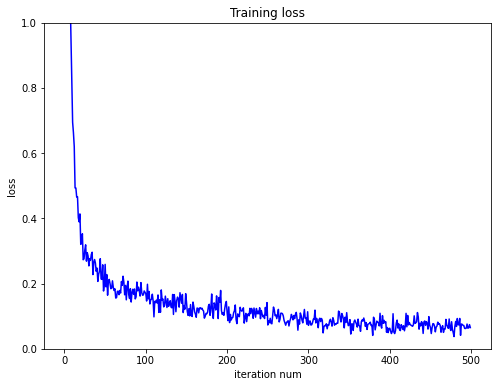

In [102]:
plot_history(coolNet_lh)

Print here your accuracy on test set. It should be around 90%.

In [103]:
# Your answer goes here. ################################################

coolNet.evaluate()
accuracy = get_accuracy(coolNet.forward(X_test), y_test_encoded)
print('Test accuracy:', accuracy)

Test accuracy: 0.9765


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [104]:
# Your beautiful code here.

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchsummary

In [105]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [106]:
# few following pieces of code are straight outta week 09 notebook
batch_size = 1000
n_epochs = 10

X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))


train_loader = DataLoader(train_dataset, batch_size,shuffle = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

In [107]:
class net(nn.Module):
    def __init__(self, num_classes = 10):

        super(self.__class__, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 196),
            nn.Dropout(0.3),
            nn.BatchNorm1d(196, eps = 1e-3, momentum = 0.75),
            nn.LeakyReLU(0.03),
            nn.Linear(196, 49),
            nn.BatchNorm1d(49, eps = 1e-3, momentum = 0.75),
            nn.LeakyReLU(0.03),
            nn.Linear(49, num_classes),
            nn.BatchNorm1d(10, eps = 1e-3, momentum = 0.75),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, input):
        return self.model(input)

In [108]:
torchsummary.summary(net().to(device), (784, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 196]         153,860
           Dropout-3                  [-1, 196]               0
       BatchNorm1d-4                  [-1, 196]             392
         LeakyReLU-5                  [-1, 196]               0
            Linear-6                   [-1, 49]           9,653
       BatchNorm1d-7                   [-1, 49]              98
         LeakyReLU-8                   [-1, 49]               0
            Linear-9                   [-1, 10]             500
      BatchNorm1d-10                   [-1, 10]              20
       LogSoftmax-11                   [-1, 10]               0
Total params: 164,523
Trainable params: 164,523
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [109]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_train_accuracy = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            out = model(X_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())
            ep_train_accuracy.append(torch_accuracy_score(y_batch, model(X_batch)))

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
                out = model(X_batch)
                loss = loss_fn(out, y_batch)

                # compute predictions
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))
        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))

        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t training loss: {train_loss[-1]:.6f}")
        print(f"\t training accuracy: {train_accuracy[-1]:.6f}")
        print(f"\t validation loss: {val_loss[-1]:.6f}")
        print(f"\t validation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, train_accuracy, val_loss, val_accuracy

In [110]:
def torch_accuracy_score(y_true, predictions):
    y_pred = predictions.max(dim=1)[1]
    return np.mean(np.array(y_true.cpu() == y_pred.cpu()))

In [111]:
model = net().to(device)

loss_func = nn.NLLLoss()

opt = torch.optim.Adam(model.parameters(), lr = 1e-1, betas=(0.9, 0.95), eps=1e-6)

tr_loss, tr_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 10 took 2.338s
	 training loss: 0.614883
	 training accuracy: 0.838740
	 validation loss: 0.234666
	 validation accuracy: 0.931
Epoch 2 of 10 took 1.176s
	 training loss: 0.256193
	 training accuracy: 0.925220
	 validation loss: 0.155116
	 validation accuracy: 0.952
Epoch 3 of 10 took 1.638s
	 training loss: 0.187341
	 training accuracy: 0.946140
	 validation loss: 0.127214
	 validation accuracy: 0.961
Epoch 4 of 10 took 1.104s
	 training loss: 0.146052
	 training accuracy: 0.956980
	 validation loss: 0.115817
	 validation accuracy: 0.965
Epoch 5 of 10 took 1.217s
	 training loss: 0.125360
	 training accuracy: 0.964860
	 validation loss: 0.101110
	 validation accuracy: 0.970
Epoch 6 of 10 took 1.728s
	 training loss: 0.106911
	 training accuracy: 0.968380
	 validation loss: 0.094584
	 validation accuracy: 0.972
Epoch 7 of 10 took 1.060s
	 training loss: 0.098140
	 training accuracy: 0.972280
	 validation loss: 0.091976
	 validation accuracy: 0.972
Epoch 8 of 10 took 1.600s
	

In [112]:
model.eval()
test_accuracy = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        predictions = model(X_batch)
        test_accuracy.append(torch_accuracy_score(y_batch.flatten(), predictions))

print('test accuracy:\t{:.3f}'.format(np.mean(test_accuracy)))

test accuracy:	0.977


In [113]:
def plot_training(tr_loss, tr_acc, val_loss, val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].set_title('Accuracy')
    axes[0].plot(tr_acc, label='Training accuracy')
    axes[0].plot(val_acc, label='Validation accuracy')
    axes[0].set_xlabel('n epoch')
    axes[0].legend()

    axes[1].set_title('Loss')
    axes[1].plot(tr_loss, label='Training loss')
    axes[1].plot(val_loss, label='Validation loss')
    axes[1].set_xlabel('n epoch')
    axes[1].legend()

    plt.show()

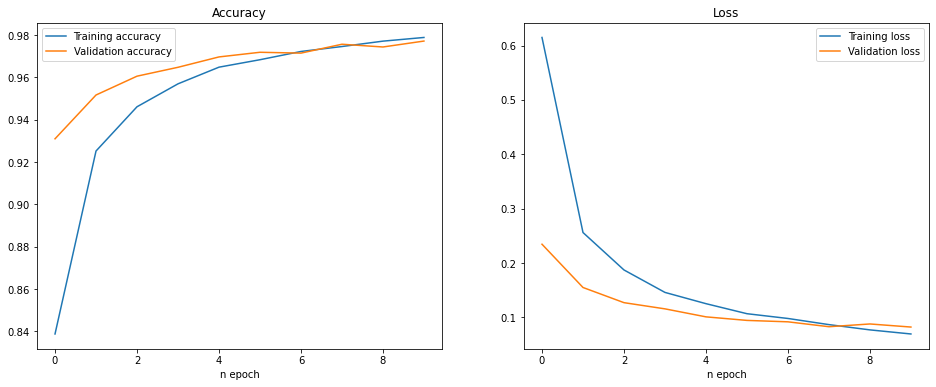

In [114]:
plot_training(tr_loss, tr_acc, val_loss, val_acc)

Можно увидеть, что точность аналогичной сети, реализованной на pytorch,
ровно та же (с точностью до округления), что и на самодельной сети.
Поведение loss-функции тоже сохранилось (хоть и в менее детализированном виде).
